# Heatmap of genomic feature colocalization created by Monte Carlo simulation


Limitations: null distribution presumes random distribution. Doesn't account for regional heterogeneity such as chromatin accessibility or different chromosomes, feature interdependence such as clustering, and assembly gaps during the randomization process. This is necessary to take into account when interpreting the results. See [Kanduri *et al.* 2019](https://doi.org/10.1093/bioinformatics/bty835).

Used metric: proportion of bases from query (shuffled) feature overlapping reference (stationary) feature

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pybedtools
from scipy import stats
import matplotlib.colors as mcolors


In [11]:
# random feature for control
chr_sizes = 'data/chr_sizes/Lsyl_chr_sizes.tsv'
randomness = pybedtools.BedTool()
randomness = randomness.random(l=15000, n=10000, g=chr_sizes)
randomness.saveas('data/peaks/randomness.bed')

<BedTool(data/peaks/randomness.bed)>

In [12]:
feature_paths = {}
# strict - no merging
feature_paths['genes'] = 'data/genes/genes_merged.bed'
feature_paths['LTR-TEs'] = 'data/dante_ltr/Lsyl_dante_ltr_merged.bed'
feature_paths['LINE'] = 'data/transposons/LINE.bed'
feature_paths['H3K4me3'] = 'data/chip-seq/consensus_peaks/H3K4_peaks.bed'
feature_paths['H3K9me2'] = 'data/chip-seq/consensus_peaks/H3K9_peaks.bed'
# merged - especially useful for distrupted arrays
feature_paths['lusy1'] = 'data/satellites/Lusy1_merged_15k.bed'
feature_paths['lusy2'] = 'data/satellites/Lusy2_merged_15k.bed'
feature_paths['centromere'] = 'data/chip-seq/consensus_peaks/CenH3_150k_merged_units.bed'
feature_paths['satellite-free_centromere'] = 'data/chip-seq/consensus_peaks/non_satellite_units.bed'
feature_paths['lusy1_functional'] = 'data/satellites/Lusy1_functional_fragments.bed'
feature_paths['lusy1_nonfunctional'] = 'data/satellites/Lusy1_nonfunctional_arrays.bed'
feature_paths['lusy2_functional'] = 'data/satellites/Lusy2_functional_fragments.bed'
feature_paths['lusy2_nonfunctional'] = 'data/satellites/Lusy2_nonfunctional_arrays.bed'
feature_paths['randomness'] = 'data/peaks/randomness.bed'




source_fasta = 'data/assembly/Lsyl.fasta'
# strict - no merging of close arrays
satellites  = 'data/satellites/Luzula_sylvatica_all_sat.bed'

rounds = 1000
pybedtools.set_tempdir('/media/kratka/DATA1/scratch')
bed_dict = {}
for feature in feature_paths:
    bed_dict[feature] = pybedtools.BedTool(feature_paths[feature]).sort().merge()


In [13]:
def simulate_coverage(feature_name, bed_dict, chr_sizes, rounds, source_fasta, exclusion_bed=None):
    feature_results_dict = {}
    beds_stationary = {}
    for feature in bed_dict:
        if feature != feature_name:
            beds_stationary[feature] = bed_dict[feature]
            feature_results_dict[feature] = []
        else:
            bed_shuffle = bed_dict[feature_name]
    feature_results_dict['gc_content'] = []
    for i in range(rounds):
        if exclusion_bed:
            shuffled_bed = bed_shuffle.shuffle(g=chr_sizes, excl=exclusion_bed)
        else:
            shuffled_bed = bed_shuffle.shuffle(g=chr_sizes)
        for stationary_feature in beds_stationary:
            shuffled_coverage = shuffled_bed.coverage(beds_stationary[stationary_feature])
            overlap_bases = shuffled_coverage.to_dataframe().iloc[:,-3].sum()
            all_bases = shuffled_coverage.to_dataframe().iloc[:,-2].sum()
            overlap_proportion = overlap_bases/all_bases
            feature_results_dict[stationary_feature].append(overlap_proportion)
        nucleotide_content = shuffled_bed.nucleotide_content(fi=source_fasta)
        at_bases = nucleotide_content.to_dataframe(comment='#').iloc[:,[-7,-4]].sum().sum()
        gc_bases = nucleotide_content.to_dataframe(comment='#').iloc[:,[-6,-5]].sum().sum()
        gc_content = gc_bases/(at_bases+gc_bases)
        feature_results_dict['gc_content'].append(gc_content)        
    percentile_dict = {}
    overlap_dict = {}
    for stationary_feature in feature_results_dict:
        if stationary_feature == 'gc_content':
            nucleotide_content = bed_shuffle.nucleotide_content(fi=source_fasta)
            at_bases = nucleotide_content.to_dataframe(comment='#').iloc[:,[-7,-4]].sum().sum()
            gc_bases = nucleotide_content.to_dataframe(comment='#').iloc[:,[-6,-5]].sum().sum()
            gc_content = gc_bases/(at_bases+gc_bases)
            overlap_dict['gc_content'] = gc_content
            percentile = stats.percentileofscore(feature_results_dict['gc_content'], gc_content)
            percentile_dict['gc_content'] = percentile
            continue
        real_coverage = bed_shuffle.coverage(beds_stationary[stationary_feature])
        overlap_bases = real_coverage.to_dataframe().iloc[:,-3].sum()
        all_bases = real_coverage.to_dataframe().iloc[:,-2].sum()
        overlap_proportion = overlap_bases/all_bases
        overlap_dict[stationary_feature] = overlap_proportion
        percentile = stats.percentileofscore(feature_results_dict[stationary_feature], overlap_proportion)
        percentile_dict[stationary_feature] = percentile
    return overlap_dict,percentile_dict,feature_results_dict
        

In [14]:
results = {}
satellite_excluded = ['genes', 'satellite-free_centromere']

In [15]:
for feature_name in bed_dict:
    print(feature_name)
    if feature_name in satellite_excluded:
        feature_results_dict = {}
        overlaps, percentiles, feature_distribution = simulate_coverage(feature_name, bed_dict, chr_sizes, rounds, source_fasta, satellites)
        feature_results_dict['overlaps'] = overlaps
        feature_results_dict['percentiles'] = percentiles
        feature_results_dict['feature_distribution'] = feature_distribution
        results[feature_name] = feature_results_dict
        
    else:
        feature_results_dict = {}
        overlaps, percentiles, feature_distribution = simulate_coverage(feature_name, bed_dict, chr_sizes, rounds, source_fasta)
        feature_results_dict['overlaps'] = overlaps
        feature_results_dict['percentiles'] = percentiles
        feature_results_dict['feature_distribution'] = feature_distribution
        results[feature_name] = feature_results_dict

genes
LTR-TEs
LINE
H3K4me3
H3K9me2
lusy1
lusy2
centromere
satellite-free_centromere
lusy1_functional
lusy1_nonfunctional
lusy2_functional
lusy2_nonfunctional
randomness


In [16]:
pybedtools.cleanup()

# percentiles to table
percentiles = {}
for feature in results:
    percentiles[feature] = results[feature]['percentiles']
percentiles_df = pd.DataFrame(percentiles).T
percentiles_df.to_csv('data/shuffled/percentiles.tsv', sep='\t')


In [19]:
# load percentiles
percentiles_df = pd.read_csv('data/shuffled/percentiles.tsv', sep='\t', index_col=0)
# clean up results table
row_subset = ['genes', 'LTR-TEs', 'H3K4me3', 'H3K9me2', 'satellite-free_centromere', 
                    'lusy1_functional', 'lusy1_nonfunctional', 'lusy2_functional', 'lusy2_nonfunctional']
short_row_labels = ['genes*', 'LTR-TEs', 'H3K4me3', 'H3K9me2', 'sat-free CENH3*', 
                    'Lusy1 func.', 'Lusy1 nonfunc.', 'Lusy2 func.', 'Lusy2 nonfunc.']
column_subset = row_subset + ['gc_content']
short_column_labels = ['genes', 'LTR-TEs', 'H3K4me3', 'H3K9me2', 'sat-free CENH3', 
                    'Lusy1 func.', 'Lusy1 nonfunc.', 'Lusy2 func.', 'Lusy2 nonfunc.', 'GC content']
# choose fetures in both rows and columns
plot_df = percentiles_df.loc[row_subset, column_subset]

# change lusy1 and lusy2 satellite colums vs non-satellite centromere rows to nan
satellite_features = ['lusy1_functional', 'lusy1_nonfunctional', 'lusy2_functional', 'lusy2_nonfunctional']
satellite_excluded_features = ['genes', 'satellite-free_centromere']
#plot_df.loc[satellite_features, satellite_excluded_features] = np.nan
plot_df.loc[satellite_excluded_features, satellite_features] = np.nan
plot_df.loc[satellite_features, satellite_excluded_features] = np.nan

# split into categories (100, 100-99, 99-1, 1-0, 0)
categories_df = plot_df.copy()
categories_df[plot_df==100] = 1
categories_df[(plot_df<100) & (plot_df>=99)] = 2
categories_df[(plot_df<99) & (plot_df>=1)] = 3
categories_df[plot_df<1] = 4
categories_df[plot_df==0] = 5
categories_df[plot_df.isna()] = np.nan

category_names = {1:'100', 2:'100-99', 3:'99-1', 4:'1-0', 5:'0'}

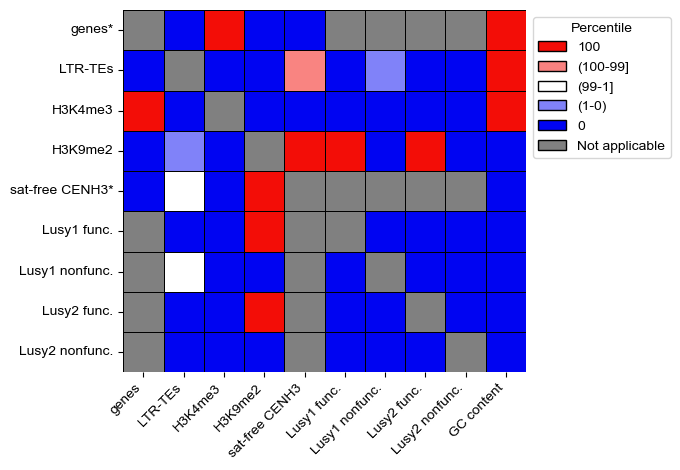

In [20]:
# Set the default font family to Arial
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# heatmap with categorical scale
# Define the colors
colors = ['#f30600f8', 'white', '#0004f2ff']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=5)
# set nan color
cmap.set_bad('grey')
fig, ax = plt.subplots()
# legend ouside the plot
legend_elements = [plt.Rectangle((0,0),1,1,facecolor='#f30600f8', edgecolor='black', label='100'),
                   plt.Rectangle((0,0),1,1,facecolor='#f98280', edgecolor='black', label='(100-99]'),
                   plt.Rectangle((0,0),1,1,facecolor='white', edgecolor='black', label='(99-1]'),
                   plt.Rectangle((0,0),1,1,facecolor='#8082f8', edgecolor='black', label='(1-0)'),
                   plt.Rectangle((0,0),1,1,facecolor='#0004f2ff', edgecolor='black', label='0'),
                   plt.Rectangle((0,0),1,1,facecolor='grey', edgecolor='black', label='Not applicable')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Percentile')
# heatmap with separation lines
sns.heatmap(categories_df, cmap=cmap, ax=ax, cbar=False, linewidths=0.5, linecolor='black', square=True)
# set labels
plt.xticks(np.arange(len(short_column_labels))+0.5, short_column_labels, rotation=45, ha='right')
plt.yticks(np.arange(len(short_row_labels))+0.5, short_row_labels, rotation=0, va='center')
plt.tight_layout()
plt.savefig('data/figures/heatmap_shuffle.svg', dpi=300)